# 💧 ABS Waterfall Simulation

This notebook provides a clean interface for running your ABS waterfall engine.

**Structure:**
1️⃣ Load YAML configuration  
2️⃣ Initialize engine  
3️⃣ Run simulation  
4️⃣ Display results (WAL, DM, repayment schedule)  
5️⃣ Plot waterfall and tranche balances

---

In [7]:
import sys, os 
sys.path.append(os.path.abspath("../src"))

In [8]:
# --- 1️⃣ Imports ---
import yaml
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
from scipy.interpolate import interp1d
from IPython.display import display

In [9]:
# === Core simulator modules ===
from abs_project.abs_deal_generator import generate_abs_deal, export_to_yaml
from abs_project.sim.loader import load_from_dict
from abs_project.sim.engine import Assumptions, WaterfallEngine
from abs_project.sim.scenario_runner import run_scenarios, style_results, plot_scenario_summary
from abs_project.sim.plots import plot_waterfall, plot_tranche_balances
from abs_project.sim.utils import tranche_repayment_summary, show_scenario_details

In [10]:


# ==============================================================
# ===              2️⃣  Generate and Load Deal               ===
# ==============================================================

abs_deal = generate_abs_deal()
yaml_path = export_to_yaml(abs_deal)
print(f"✅ YAML file generated at: {yaml_path}")

with open(yaml_path, "r") as f:
    abs_data = yaml.safe_load(f)

print(f"✅ Loaded deal configuration: {abs_data['deal']['deal_name']}")
pprint(abs_data['deal'])

✅ YAML file created: /workspaces/ABS-Simulator/abs_project/src/data/deals/AUTOFR_2024-3.yaml
✅ YAML file generated at: /workspaces/ABS-Simulator/abs_project/src/data/deals/AUTOFR_2024-3.yaml
✅ Loaded deal configuration: AUTOFR 2024-3
{'benchmark_curve': 'EURIBOR_1M',
 'currency': 'EUR',
 'day_count': 'ACT/360',
 'deal_name': 'AUTOFR 2024-3',
 'frequency': 'Monthly',
 'issuer': 'Crédit Agricole Consumer Finance',
 'periods': 60,
 'start_date': '2025-01-01'}


In [11]:
euribor_curve = pd.DataFrame({
    "tenor_yrs": [0.25, 0.5, 1, 2, 3, 5, 7, 10],
    "rate": [0.037, 0.038, 0.039, 0.040, 0.041, 0.042, 0.043, 0.044],
})
curve_fn = interp1d(euribor_curve["tenor_yrs"], euribor_curve["rate"], fill_value="extrapolate")

print("✅ EURIBOR term-structure ready:")
display(euribor_curve)

✅ EURIBOR term-structure ready:


,tenor_yrs,rate
0,0.25,0.037
1,0.50,0.038
2,1.00,0.039
3,2.00,0.040
4,3.00,0.041
5,5.00,0.042
6,7.00,0.043
7,10.00,0.044


## 🧾 2️⃣ Load Deal Configuration

In [12]:
scenarios = [
    Assumptions(
        CPR_annual=0.04, CDR_annual=0.01, recovery_rate=0.40,
        stepdown_month=24, oc_trigger=1.10, scenario_name="Base"
    ),
    Assumptions(
        CPR_annual=0.08, CDR_annual=0.02, recovery_rate=0.30,
        stepdown_month=24, oc_trigger=1.10, scenario_name="Stress"
    ),
]

## ⚙️ 3️⃣ Initialize Simulation Engine

In [13]:
df_results = run_scenarios(
    abs_data,
    scenarios,
    base_index_annual=0.026,
    curve_fn=curve_fn,     # 👈 Now using real curve
    plot=False
)

display(style_results(df_results))

Scenario,Tranche,WAL (yrs),DM (bps),Total Interest (€),Total Principal (€),Total Residual (€),CPR (%),CDR (%),Recovery (%)
Base,A,1.64,87,"5,522,003","68,571,814",0,4.0,1.0,40.0
Base,B,3.46,200,"892,671","4,704,426",0,4.0,1.0,40.0
Base,C,3.63,413,"412,213","1,786,983",0,4.0,1.0,40.0
Base,Equity,0.00,nan,0,0,0,4.0,1.0,40.0
Base,Equity_residual,0.00,0,0,0,"14,564,390",4.0,1.0,40.0
Stress,A,1.42,86,"4,744,211","68,571,814",0,8.0,2.0,30.0
Stress,B,3.06,207,"786,517","4,704,426",0,8.0,2.0,30.0
Stress,C,3.22,435,"364,510","1,786,983",0,8.0,2.0,30.0
Stress,Equity,0.00,nan,0,0,0,8.0,2.0,30.0
Stress,Equity_residual,0.00,0,0,0,"14,533,182",8.0,2.0,30.0


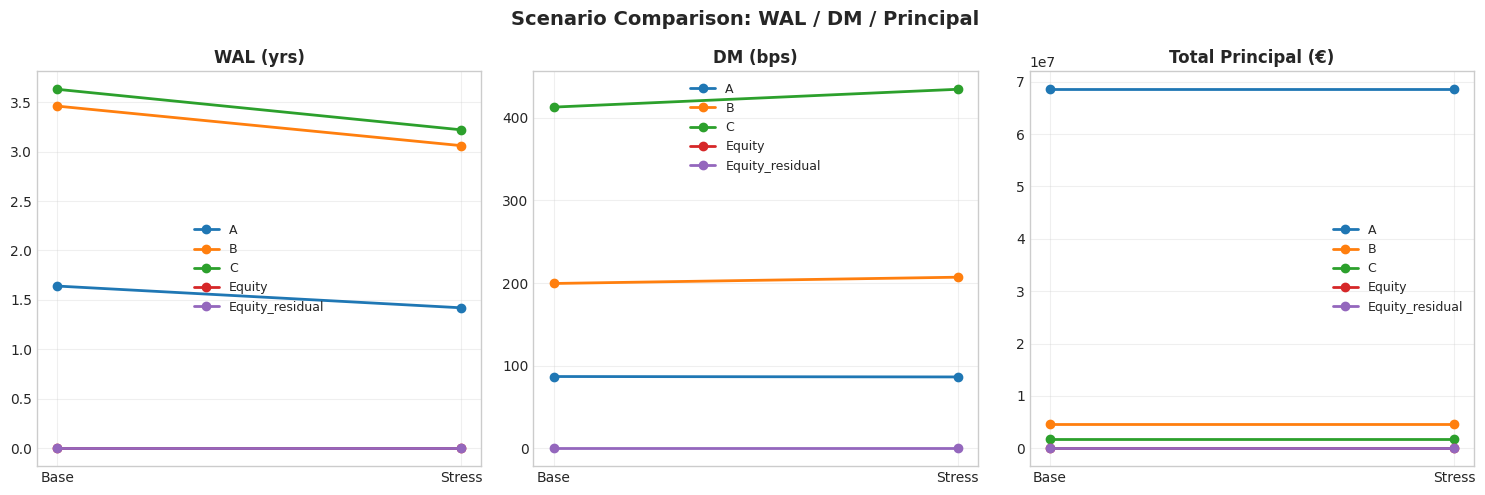

In [14]:
plot_scenario_summary(df_results)


💰 Tranche Repayment Summary
  • A: fully repaid after 40 months (3.33 years)
  • B: fully repaid after 43 months (3.58 years)
  • C: fully repaid after 44 months (3.67 years)
  • Equity: no repayments recorded


None

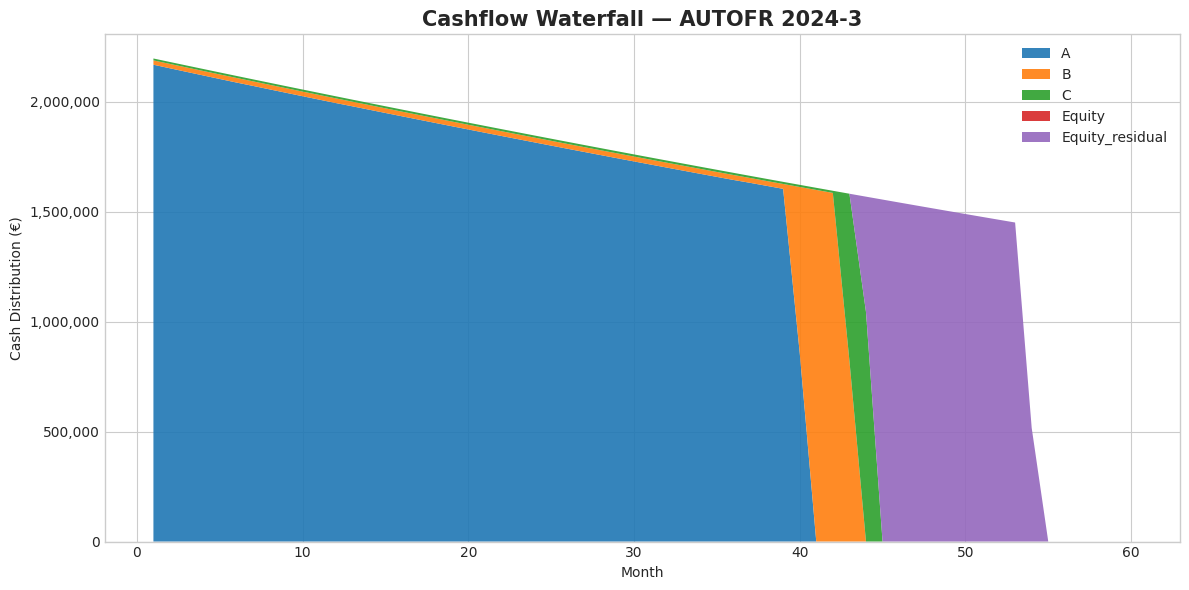

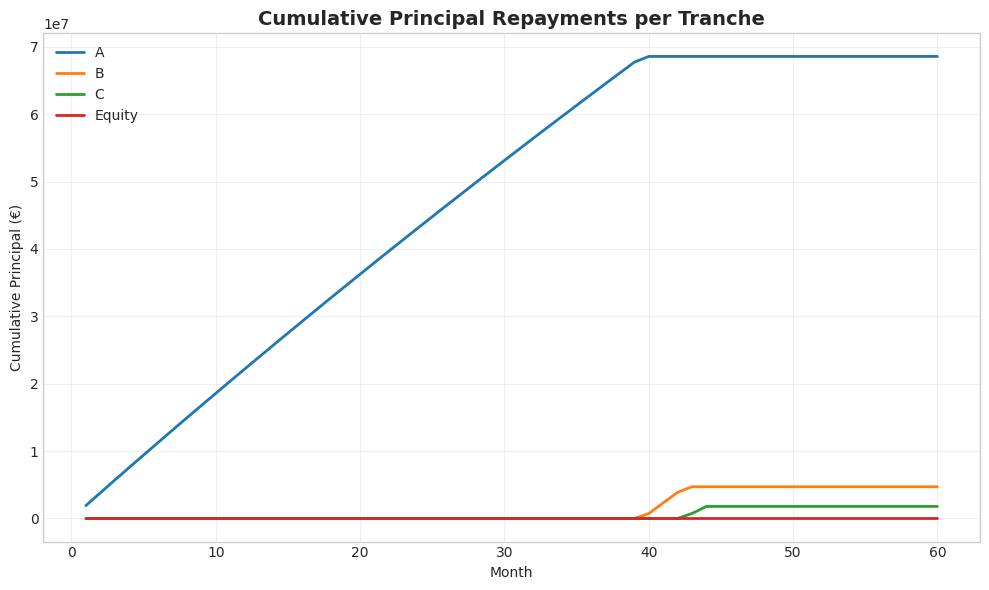


📘 Scenario details: Base

💰 Tranche Repayment Summary
  • A: fully repaid after 40 months (3.33 years)
  • B: fully repaid after 43 months (3.58 years)
  • C: fully repaid after 44 months (3.67 years)
  • Equity: no repayments recorded


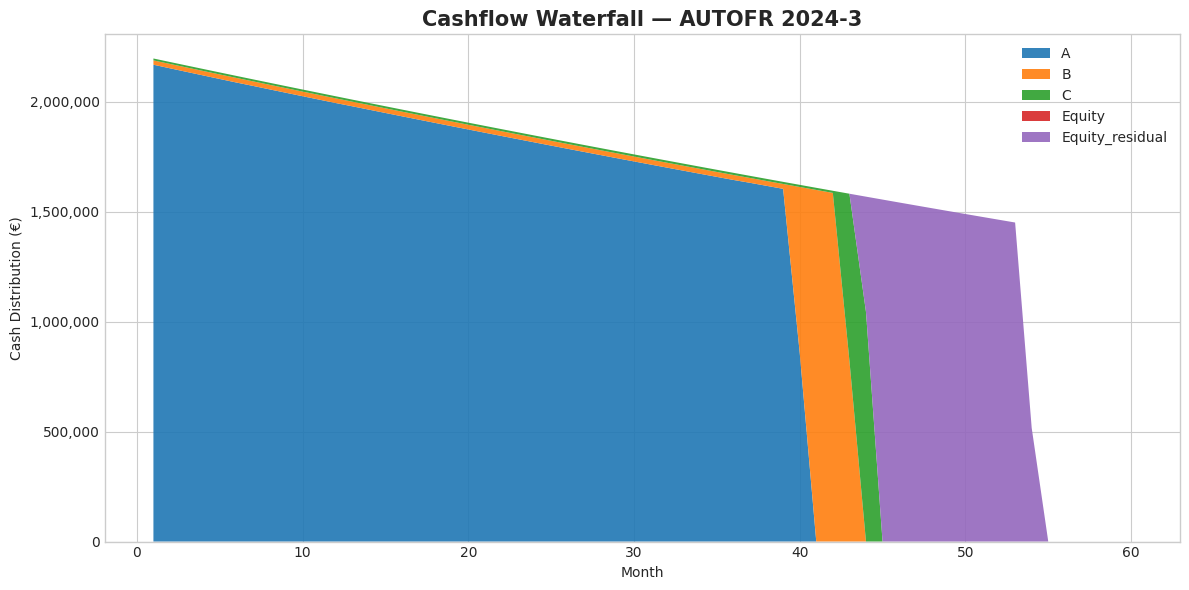

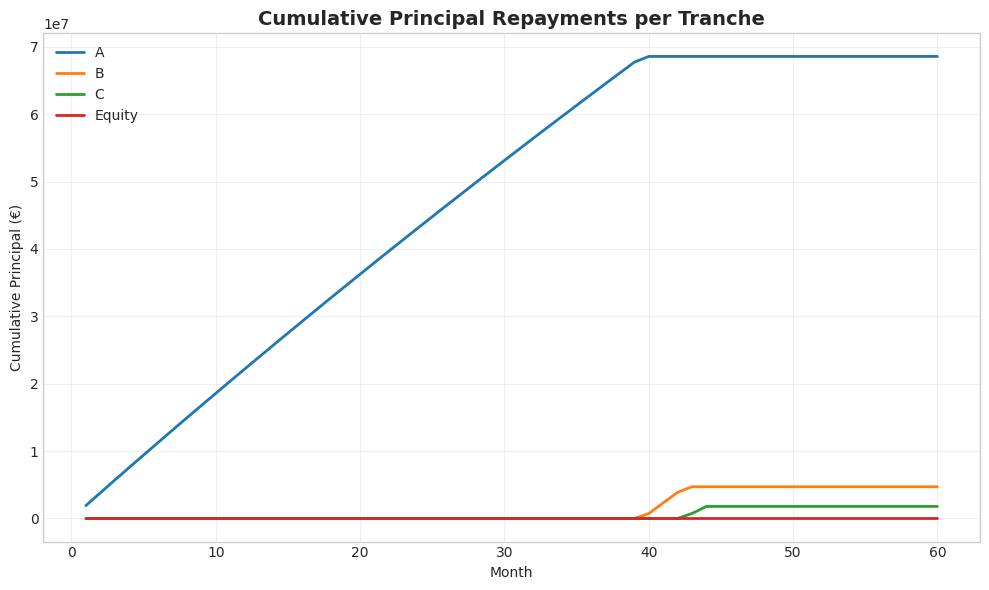

In [15]:


# ==============================================================
# ===              7️⃣  Deep-Dive on One Scenario             ===
# ==============================================================

deal, pool, tranches, _ = load_from_dict(abs_data)

# pick Base scenario
engine = WaterfallEngine(
    deal, pool, tranches,
    assumptions=scenarios[0],
    base_index_annual=0.026,
    curve_fn=curve_fn,
)
engine.simulate()

# --- Detailed tranche repayment summary ---
display(tranche_repayment_summary(engine))

# --- Waterfall and tranche balance plots ---
plot_waterfall(engine)
plot_tranche_balances(engine)

# --- Full scenario detail view ---
show_scenario_details(engine)